<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Purpose" data-toc-modified-id="Purpose-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Purpose</a></span></li><li><span><a href="#Input" data-toc-modified-id="Input-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Input</a></span></li><li><span><a href="#Output" data-toc-modified-id="Output-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Output</a></span></li><li><span><a href="#Parameters" data-toc-modified-id="Parameters-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Parameters</a></span><ul class="toc-item"><li><span><a href="#Not-through-papermill" data-toc-modified-id="Not-through-papermill-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Not through papermill</a></span></li></ul></li><li><span><a href="#Load-Cell-Metadata" data-toc-modified-id="Load-Cell-Metadata-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Load Cell Metadata</a></span></li><li><span><a href="#Basic-metrics-distribution" data-toc-modified-id="Basic-metrics-distribution-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Basic metrics distribution</a></span></li><li><span><a href="#Filter-by-basic-QC-metrics" data-toc-modified-id="Filter-by-basic-QC-metrics-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Filter by basic QC metrics</a></span></li><li><span><a href="#Other-Stats" data-toc-modified-id="Other-Stats-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Other Stats</a></span></li><li><span><a href="#Plateview-of-key-metrics" data-toc-modified-id="Plateview-of-key-metrics-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Plateview of key metrics</a></span></li></ul></div>

# Basic Data Walkthrough and Cell Mapping Metric Filtering

## Purpose
- Overview of basic QC metrics per brain region
- Have a simple cell filtering based on basic QC metrics

## Input
- Cell metadata table

## Output
- Selected cell metadata table

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from cemba_data.plot.preprocessing import cutoff_vs_cell_remain, plot_on_plate

In [3]:
result_dir = pathlib.Path()
fig_dir = result_dir / 'fig/cell_basic_qc'
fig_dir.mkdir(exist_ok=True, parents=True)

## Parameters

In [4]:
# parameters cell
study_name = ''

cell_metadata_path = ''

In [5]:
# Parameters
study_name = "4B"
cell_metadata_path = "/home/hanliu/project/mouse_rostral_brain/study/DissectionRegions/4B/CellMetadata.msg"


### Not through papermill

In [6]:
# QC metric filtering
qc_metric = {
    'CCC_Rate': (0, 0.05),
    'CG_RateAdj': (0.5, 1),
    'CH_RateAdj': (0., 0.15),
    'FinalReads': (500000, 10000000),
    'MappingRate': (0.5, 1)
}

# plot cell metadata columns
metadata_distribution_plot = {
    'CCC_Rate': (0., 0.1),
    'CH_RateAdj': (0, 0.1),
    'CG_RateAdj': (0.7, 0.9),
    'InputReads': (0, 1e7),
    'MappedReads': (0, 1e7),
    'FinalReads': (0, 1e7),
    'MappingRate': (0.5, 1)
}

final_reads_column = 'FinalReads'
plate_view = False

## Load Cell Metadata

In [7]:
total_cell_meta = pd.read_msgpack(cell_metadata_path)

In [8]:
cell_metadata_include = {}
cell_metadata_exclude = {}

# apply cell metadata and cell list selection first
judges = []
for k, v in cell_metadata_include.items():
    judges.append(total_cell_meta[k].isin(v))
for k, v in cell_metadata_exclude.items():
    judges.append(~total_cell_meta[k].isin(v))

if len(judges) != 0:
    cell_meta = total_cell_meta[np.all(judges, axis=0)].copy()
else:
    cell_meta = total_cell_meta

## Basic metrics distribution

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


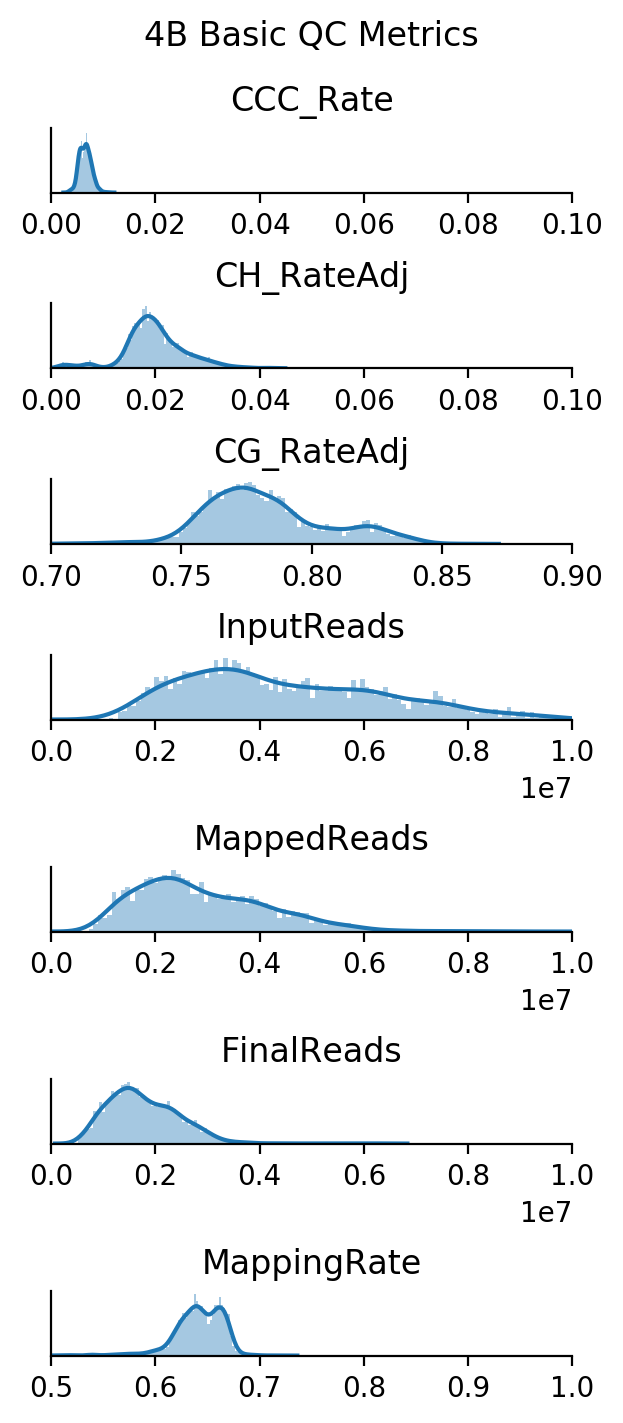

In [9]:
nrows = len(metadata_distribution_plot)
if nrows != 0:
    fig, axes = plt.subplots(nrows=nrows,
                             constrained_layout=True,
                             figsize=(3, nrows),
                             dpi=200)
    for (col, xlim), ax in zip(metadata_distribution_plot.items(), axes.flat):
        _data = cell_meta[col]
        _data = _data[(_data <= xlim[1]) & (_data >= xlim[0])]
        sns.distplot(_data, ax=ax, bins=100)
        ax.set(xlim=xlim, yticks=[], xlabel='', title=col)
    sns.despine(fig=fig, trim=True)

    fig.suptitle(f'{study_name} Basic QC Metrics')

    fig.savefig(fig_dir / f'basic_qc_metric.pdf')

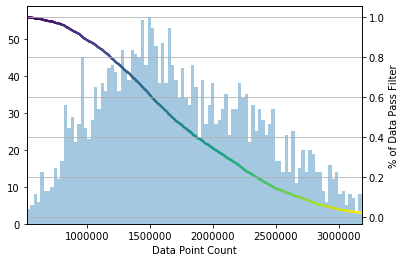

In [10]:
try:
    fig, axes = cutoff_vs_cell_remain(cell_meta[final_reads_column],
                                      xlim_quantile=(0.001, 0.98))
    fig.savefig(fig_dir / 'FinalReads distribution')
except KeyError:
    print(f'{final_reads_column} not in cell_meta, skip')

## Filter by basic QC metrics

In [11]:
judges = []
for col, (vmin, vmax) in qc_metric.items():
    judge = (cell_meta[col] >= vmin) & (cell_meta[col] <= vmax)
    print(
        f'{col} passed {judge.sum()}/{judge.size} ({(100*judge.sum()/judge.size):.1f}%)'
    )
    judges.append(judge)
cell_meta['PassFilter'] = np.all(judges, axis=0)

total_number = cell_meta['PassFilter'].sum()
print(
    f'Overall passed {total_number}/{judge.size} ({(100*total_number/cell_meta.shape[0]):.1f}%)'
)

CCC_Rate passed 2768/2768 (100.0%)
CG_RateAdj passed 2768/2768 (100.0%)
CH_RateAdj passed 2768/2768 (100.0%)
FinalReads passed 2768/2768 (100.0%)
MappingRate passed 2768/2768 (100.0%)
Overall passed 2768/2768 (100.0%)


In [12]:
cell_meta.to_msgpack('CellMetadata.AfterQC.msg')

## Other Stats

In [13]:
print('Cells pass basic QC in each batch:')
for k, v in cell_meta.groupby('FACS_Date')['PassFilter'].sum().astype(
        int).items():
    print(k, v)

Cells pass basic QC in each batch:
171212 283
171213 1195
180104 1290


In [14]:
print('Cells pass basic QC in each random index:')
for k, v in cell_meta.groupby('index_name')['PassFilter'].sum().astype(
        int).items():
    print(k, v, f'{v/3.84:.1f}%')

Cells pass basic QC in each random index:
ad001 334 87.0%
ad002 363 94.5%
ad004 349 90.9%
ad006 372 96.9%
ad007 347 90.4%
ad008 325 84.6%
ad010 350 91.1%
ad012 328 85.4%


## Plateview of key metrics

In [15]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'FinalReads',
                              'Plate',
                              vmin=5e5,
                              vmax=3e6,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.FinalReads.pdf')

In [16]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CG_RateAdj',
                              'Plate',
                              vmin=0.65,
                              vmax=0.85,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CG_RateAdj.pdf')

In [17]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CH_RateAdj',
                              'Plate',
                              vmin=0,
                              vmax=0.05,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CH_RateAdj.pdf')

In [18]:
cell_meta

,AllcPath,CCC_Rate,CG_Rate,CG_RateAdj,CH_Rate,CH_RateAdj,FinalReads,InputReads,MappedReads,Region,...,l2-umap_0,l2-umap_1,l2-tsne_0,l2-tsne_1,SubType,l3-umap_0,l3-umap_1,l3-tsne_0,l3-tsne_1,PassFilter
4B_M_0,/gale/raidix/rdx-4/CEMBA_RS1/4B/CEMBA180104_4B...,0.00533,0.76296,0.76169,0.02159,0.01635,1313244.0,2849002,1915099.0,4B,...,-2.437826,-10.641282,-26.549121,45.278496,IT-L23 Cux1,4.788461,5.924384,32.395997,0.896758,True
4B_M_1,/gale/raidix/rdx-4/CEMBA_RS1/4B/CEMBA180104_4B...,0.00564,0.75499,0.75360,0.02501,0.01948,1909014.0,4390774,2915826.0,4B,...,1.626733,-13.115237,-3.477641,40.529120,IT-L23 Cux1,-3.228565,6.057029,-4.947766,-13.925335,True
4B_M_10,/gale/raidix/rdx-4/CEMBA_RS1/4B/CEMBA180104_4B...,0.00400,0.75726,0.75629,0.01164,0.00767,1056918.0,2167402,1456393.0,4B,...,0.707668,-10.113982,23.364163,9.208686,ODC odc-large,0.215154,3.085597,0.272822,0.997425,True
4B_M_100,/gale/raidix/rdx-4/CEMBA_RS1/4B/CEMBA180104_4B...,0.00522,0.77313,0.77194,0.02024,0.01510,1524213.0,3455666,2323979.0,4B,...,20.026237,5.188268,-49.594770,-10.463128,CT-L6 Megf9,-6.354868,-8.927410,-0.078029,33.071046,True
4B_M_1000,/gale/raidix/rdx-4/CEMBA_RS1/4B/CEMBA180104_4B...,0.00558,0.78429,0.78308,0.02703,0.02157,950728.0,2276578,1478257.0,4B,...,13.483556,-13.223809,27.975176,26.109621,IT-L5 Grik3,10.017477,3.058780,-30.825498,11.902587,True
4B_M_1001,/gale/raidix/rdx-4/CEMBA_RS1/4B/CEMBA180104_4B...,0.00706,0.80414,0.80275,0.03350,0.02663,1508746.0,3655858,2367200.0,4B,...,23.973635,5.981852,-22.105216,-13.154979,CT-L6 Hcrtr2,-7.713341,-21.639874,-32.453645,10.016579,True
4B_M_1002,/gale/raidix/rdx-4/CEMBA_RS1/4B/CEMBA180104_4B...,0.00563,0.76962,0.76832,0.02347,0.01794,1276231.0,2865546,1931003.0,4B,...,5.330657,-14.785851,-29.543496,-0.894915,IT-L4 Shc3,-2.882193,-0.415604,-13.678072,25.278454,True
4B_M_1003,/gale/raidix/rdx-4/CEMBA_RS1/4B/CEMBA180104_4B...,0.00697,0.81328,0.81197,0.03338,0.02660,1603182.0,3585010,2420905.0,4B,...,-24.239498,1.112885,-44.715648,-0.858274,MGE-Sst Frmd6,4.115822,-10.596560,-17.941025,11.707302,True
4B_M_1004,/gale/raidix/rdx-4/CEMBA_RS1/4B/CEMBA180104_4B...,0.00563,0.76249,0.76115,0.02357,0.01804,1693176.0,4091874,2718334.0,4B,...,-1.885703,-14.523096,-2.499219,60.141654,IT-L23 Cux1,0.742461,11.904624,16.590667,-43.167102,True
4B_M_1005,/gale/raidix/rdx-4/CEMBA_RS1/4B/CEMBA180104_4B...,0.00580,0.82519,0.82417,0.02558,0.01990,1158292.0,2777092,1836623.0,4B,...,26.350378,1.512679,-1.529169,-37.852572,NP-L6 Olfml2b,6.147922,-2.093143,-3.458879,9.447652,True
